# <font color = 'teal'> Import Libraries </font>

In [2]:
# Basic data manipulation
import numpy as np
import math
import pandas as pd
pd.set_option('display.max_columns', 20)
import datetime as dt

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# <font color = 'teal'> Read and Inspect Data </font>

In [3]:
#source = pd.ExcelFile(r"C:\Users\mcondon\Documents\GitHub\Cohort-analysis\Online Retail.xlsx")
#GitHub data location
data = 'https://github.com/michael-william/Cohort-analysis/raw/master/Online%20Retail.xlsx'
source = pd.ExcelFile(data)

In [4]:
online = pd.read_excel(source, 'Online Retail')

In [5]:
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
online.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [8]:
#Dropping nulls
online = online.dropna().reset_index(drop=True)

In [9]:
#Sorting to make it easier to spot check
online = online.sort_values('CustomerID').reset_index(drop=True)

### Assign daily acquisition cohort (CohortDay)##

In [10]:
# Define a function that will parse the date
def get_day(x): 
    return dt.datetime(x.year, x.month, x.day) 

# Create InvoiceDay column
online['InvoiceDay'] = online['InvoiceDate'].apply(get_day) 

# Group by CustomerID and select the InvoiceDay value
grouping = online.groupby('CustomerID')['InvoiceDay'] 

# Assign a minimum InvoiceDay value to the dataset
online['CohortDay'] = grouping.transform('min').astype('datetime64[ns]')

# View the top 5 rows
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18
2,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,2011-08-02,2010-12-07
3,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07
4,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07


### Calculate time offset in days - part 1##

In [11]:
def get_date_int(df, column):
    year = df[column].dt.year
    month = df[column].dt.month
    day = df[column].dt.day
    return year, month, day

In [12]:
# Get the integers for date parts from the `InvoiceDay` column
invoice_year, invoice_month, invoice_day = get_date_int(online, 'InvoiceDay')

# Get the integers for date parts from the `CohortDay` column
cohort_year, cohort_month, cohort_day = get_date_int(online, 'CohortDay')

### Calculate time offset in days - part 2 (ChortIndex)

In [13]:
# Calculate difference in years
years_diff = invoice_year - cohort_year

# Calculate difference in months
months_diff = invoice_month - cohort_month

# Calculate difference in days
days_diff = invoice_day - cohort_day

# Extract the difference in days from all previous values
online['CohortIndex'] = years_diff * 365 + months_diff * 30 + days_diff + 1
online.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceDay,CohortDay,CohortIndex
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18,1
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,2011-01-18,2011-01-18,1
2,562032,21578,WOODLAND DESIGN COTTON TOTE BAG,6,2011-08-02 08:48:00,2.25,12347.0,Iceland,2011-08-02,2010-12-07,241
3,542237,47559B,TEA TIME OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07,55
4,542237,21154,RED RETROSPOT OVEN GLOVE,10,2011-01-26 14:30:00,1.25,12347.0,Iceland,2011-01-26,2010-12-07,55


In [14]:
# Converting CohortIndex to months from days
online['CohortIndex'] = np.ceil(np.divide(online.CohortIndex,30)).astype('int')

# <font color = 'teal'> Cohort Metrics </font>

### Calculate retention from scratch

In [15]:
#Adding CohortMonth from CohortDay in dt format
online['CohortMonth'] =  online.CohortDay + pd.offsets.MonthBegin(1)

In [16]:
grouping = online.groupby(['CohortMonth', 'CohortIndex'])

In [17]:
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

In [18]:
# Count the number of unique values per customer ID
cohort_data = grouping['CustomerID'].apply(pd.Series.nunique).reset_index()

# Create a pivot 
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Select the first column and store it to cohort_sizes
cohort_sizes = cohort_counts.iloc[:,0]

# Divide the cohort count by cohort sizes along the rows
retention = (cohort_counts.divide(cohort_sizes, axis=0) * 100).round(2)
retention.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,100.0,38.29,34.49,38.50,36.29,39.03,37.03,35.44,34.92,38.29,40.61,50.74,19.73
2011-02-01,100.0,24.70,28.98,30.40,30.17,28.98,25.65,27.55,33.73,35.15,28.50,1.43,NaN
2011-03-01,100.0,23.42,23.95,29.47,20.79,26.84,25.53,27.89,28.95,25.00,0.79,NaN,NaN
2011-04-01,100.0,18.64,25.00,23.18,19.55,22.05,24.32,27.05,21.82,2.50,NaN,NaN,NaN
2011-05-01,100.0,27.42,17.73,22.41,18.39,23.75,24.75,22.74,2.34,NaN,NaN,NaN,NaN


### Calculate average price

In [19]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['UnitPrice'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_price = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='UnitPrice')
average_price = average_price.round(2)
average_price.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,3.20,3.19,3.23,3.57,2.90,4.99,3.15,3.25,3.45,3.08,3.21,2.85,2.81
2011-02-01,3.50,3.38,7.34,3.12,3.33,2.88,2.77,2.72,5.63,3.00,2.77,2.36,NaN
2011-03-01,3.52,4.78,2.94,3.14,2.97,2.72,3.19,3.00,2.89,3.06,2.54,NaN,NaN
2011-04-01,3.49,3.86,3.32,3.53,3.08,2.79,2.77,2.79,2.66,3.15,NaN,NaN,NaN
2011-05-01,3.42,3.82,3.16,2.86,2.88,2.88,2.72,2.91,2.54,NaN,NaN,NaN,NaN


### Calculate average quantity

In [20]:
# Create a groupby object and pass the monthly cohort and cohort index as a list
grouping = online.groupby(['CohortMonth', 'CohortIndex']) 

# Calculate the average of the unit price column
cohort_data = grouping['Quantity'].mean()

# Reset the index of cohort_data
cohort_data = cohort_data.reset_index()

# Create a pivot 
average_quantity = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='Quantity')
average_quantity = average_quantity.round(1)
average_quantity.head()

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2011-01-01,11.3,14.5,14.1,15.0,14.6,13.3,14.4,17.5,14.8,17.2,16.9,13.0,13.1
2011-02-01,9.8,15.2,11.3,10.7,12.7,15.4,14.2,14.0,11.4,8.5,9.2,12.2,NaN
2011-03-01,10.8,13.9,16.1,11.8,10.4,13.2,13.0,11.2,10.0,13.8,18.8,NaN,NaN
2011-04-01,9.7,11.0,11.8,9.9,13.8,13.9,10.8,13.7,9.3,5.7,NaN,NaN,NaN
2011-05-01,9.8,8.7,11.8,11.3,11.1,8.6,9.3,9.5,5.6,NaN,NaN,NaN,NaN


# <font color = 'teal'>Cohot Analysis Visualization</font>

No handles with labels found to put in legend.


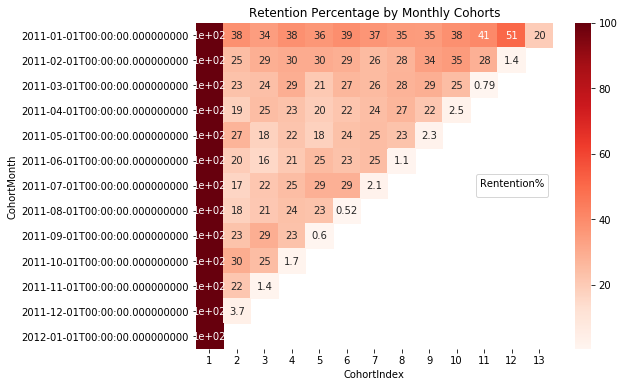

In [21]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Retention Percentage by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = retention, annot=True, cmap='Reds')
plt.yticks(rotation = 0)
ax.legend(loc = 'right' , title = "Rentention%")
plt.show()

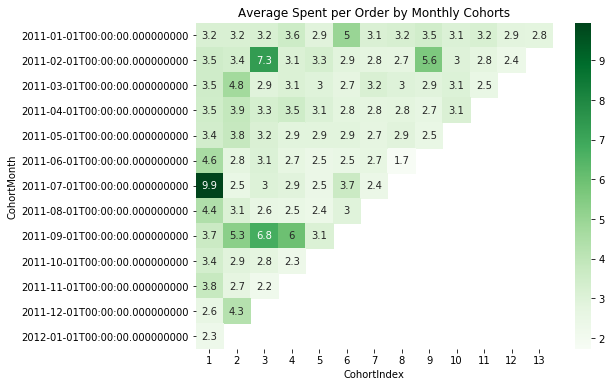

In [22]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Spent per Order by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = average_price, annot=True, cmap='Greens')
plt.yticks(rotation = 0)
plt.show()

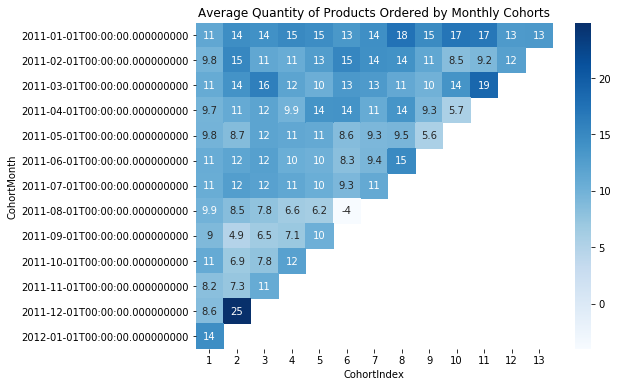

In [23]:
# Initialize an 8 by 6 inches plot figure
plt.figure(figsize=(8, 6))

# Add a title
plt.title('Average Quantity of Products Ordered by Monthly Cohorts')

# Create the heatmap
ax = sns.heatmap(data = average_quantity, annot=True, cmap='Blues')
plt.yticks(rotation = 0)
plt.show()

# <font color = 'teal'>RFM Sementation Recency Frequency Monetary</font>
https://en.wikipedia.org/wiki/RFM_(market_research)
- Recency - days since last customer transaction
- Frequecy - number of transaction in the last 12 months
- Monetary Value - total spend in last 12 months

**Can group by:**
  - Percentiles (chosen for this project)
  > 1. Sort customers based on percentile
  > 2. Break customers into a pre-defined number of groups of equal size
  > 3. Assign a label to each group
  - Pareto 80/20 cut
  - Custom, based on business knowledge


### Adjusting data to only last 12 months of invoices

In [24]:
print('Min invoice date:{}; Max invoice data:{}'.format(min(online.InvoiceDate), max(online.InvoiceDate)))

Min invoice date:2010-12-01 08:26:00; Max invoice data:2011-12-09 12:50:00


In [25]:
#Data is already adjusted to last 12 months 
#Data is old, so creating hypothetical snap_shot data as if we're doing analysis recently
snapshot_date = max(online.InvoiceDate) + dt.timedelta(days=1)

### Calculate RFM Metrics

In [26]:
# Aggregate data on a customer level

In [27]:
rfm = online.groupby('CustomerID')
rfm = rfm.agg(Recency = ('InvoiceDate','max'),
            Frequency = ('InvoiceNo','size'),
           Monetary_Value = ('UnitPrice', 'sum'))

In [28]:
day_diff = snapshot_date - rfm.Recency

In [29]:
recency_days = []
for x in rfm.Recency:
    diff = snapshot_date-x
    diff = diff/np.timedelta64(1,"D")
    diff = np.ceil(diff).astype('int')
    recency_days.append(diff)

In [30]:
rfm['Recency'] = recency_days

In [31]:
rfm.index = rfm.index.astype('int')
rfm.index.name='CustomerID'
rfm

,Recency,Frequency,Monetary_Value
CustomerID,,,
12346,327,2,2.08
12347,3,182,481.21
12348,76,31,178.71
12349,20,73,605.10
12350,311,17,65.30
...,...,...,...
18280,279,10,47.65
18281,182,7,39.36
18282,9,13,62.68


In [32]:
rfm = rfm[rfm.Monetary_Value != 0]

### Building RFM segments

In [33]:
# Generator of labels for recency where 4 is best and 1 is worst
r_labels = range(4,0,-1)

# Recency quartiles
r_quartiles = pd.qcut(rfm.Recency,4,labels=r_labels)

# Append recency quartiles to dataframe
rfm['R'] = r_quartiles

C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [34]:
# Generator of labels for frequency and monetary where 1 is best and 4 is worst
f_labels = range(1,5)
m_labels = range(1,5)

# frequency and monetary quartiles
f_quartiles = pd.qcut(rfm.Frequency,4,labels=f_labels)
m_quartiles = pd.qcut(rfm.Monetary_Value,4,labels=m_labels)

# Append recency quartiles to dataframe
rfm['F'] = f_quartiles
rfm['M'] = m_quartiles
rfm

C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


,Recency,Frequency,Monetary_Value,R,F,M
CustomerID,,,,,,
12346,327,2,2.08,1,1,1
12347,3,182,481.21,4,4,4
12348,76,31,178.71,2,2,3
12349,20,73,605.10,3,3,4
12350,311,17,65.30,1,1,2
...,...,...,...,...,...,...
18280,279,10,47.65,1,1,1
18281,182,7,39.36,1,1,1
18282,9,13,62.68,4,1,2


In [35]:
# Creating RFM segement
def join_rfm(x):
    return str(x.R) + str(x.F) + str(x.M)

rfm['Segment'] = rfm.apply(join_rfm,axis=1)
rfm

C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,Recency,Frequency,Monetary_Value,R,F,M,Segment
CustomerID,,,,,,,
12346,327,2,2.08,1,1,1,111
12347,3,182,481.21,4,4,4,444
12348,76,31,178.71,2,2,3,223
12349,20,73,605.10,3,3,4,334
12350,311,17,65.30,1,1,2,112
...,...,...,...,...,...,...,...
18280,279,10,47.65,1,1,1,111
18281,182,7,39.36,1,1,1,111
18282,9,13,62.68,4,1,2,412


In [36]:
rfm['Score'] = rfm[['R','F','M']].sum(axis=1).astype('int')
rfm

C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Recency,Frequency,Monetary_Value,R,F,M,Segment,Score
CustomerID,,,,,,,,
12346,327,2,2.08,1,1,1,111,3
12347,3,182,481.21,4,4,4,444,12
12348,76,31,178.71,2,2,3,223,7
12349,20,73,605.10,3,3,4,334,10
12350,311,17,65.30,1,1,2,112,4
...,...,...,...,...,...,...,...,...
18280,279,10,47.65,1,1,1,111,3
18281,182,7,39.36,1,1,1,111,3
18282,9,13,62.68,4,1,2,412,7


### Analyzinf RFM Segments

In [37]:
# Calculate size of segments
rfm.groupby('Segment').size().sort_values(ascending=False)[:10]

Segment
444    505
111    414
344    266
211    254
122    235
222    217
333    214
233    202
433    199
322    150
dtype: int64

In [38]:
# Select bottom RFM segment '111' and view top 5
rfm[rfm.Segment == '111'][:5]

,Recency,Frequency,Monetary_Value,R,F,M,Segment,Score
CustomerID,,,,,,,,
12346,327,2,2.08,1,1,1,111,3
12353,205,4,24.30,1,1,1,111,3
12361,288,10,33.35,1,1,1,111,3
12386,339,10,23.91,1,1,1,111,3
12401,304,5,48.40,1,1,1,111,3


In [39]:
# Summary metrics for RFM Score
rfm.groupby('Score').agg(Recency_avg = ('Recency','mean'),
                         Frequency_avg = ('Frequency','mean'), 
                         Monetary_avg =('Monetary_Value','mean'))

,Recency_avg,Frequency_avg,Monetary_avg
Score,,,
3,263.176329,7.442029,22.772488
4,145.153266,11.776382,37.017286
5,153.971602,19.590264,64.008765
6,95.773389,25.187110,183.321580
7,96.874715,41.157175,136.997246
8,61.713978,54.348387,182.394475
9,50.826425,80.968912,253.641117
10,33.813107,108.075243,400.433325
11,24.693122,195.044974,652.317698


In [40]:
# Review distiburion of RFM Score
rfm.Score.describe()

count    4371.000000
mean        7.501716
std         2.868145
min         3.000000
25%         5.000000
50%         7.000000
75%        10.000000
max        12.000000
Name: Score, dtype: float64

In [41]:
# function for grouping into named segemnts by RFM Score
def segment_me(df):
    if df['Score'] >= 10:
        return 'Gold'
    elif df['Score'] >=6 and (df['Score'] < 10):
        return 'Silver'
    else:
        return 'Bronze'

In [42]:
rfm['General_Segment'] = rfm.apply(segment_me, axis=1)
rfm

C:\Users\mcondon\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Recency,Frequency,Monetary_Value,R,F,M,Segment,Score,General_Segment
CustomerID,,,,,,,,,
12346,327,2,2.08,1,1,1,111,3,Bronze
12347,3,182,481.21,4,4,4,444,12,Gold
12348,76,31,178.71,2,2,3,223,7,Silver
12349,20,73,605.10,3,3,4,334,10,Gold
12350,311,17,65.30,1,1,2,112,4,Bronze
...,...,...,...,...,...,...,...,...,...
18280,279,10,47.65,1,1,1,111,3,Bronze
18281,182,7,39.36,1,1,1,111,3,Bronze
18282,9,13,62.68,4,1,2,412,7,Silver


In [43]:
segments = rfm.groupby('General_Segment').agg(Size = ('General_Segment','count'),
                                   Recency_avg = ('Recency','mean'), 
                                   Frequency_avg = ('Frequency','mean'), 
                                   Monetary_avg = ('Monetary_Value', 'mean')).round(1).reindex(['Gold', 'Silver', 'Bronze'])
segments

,Size,Recency_avg,Frequency_avg,Monetary_avg
General_Segment,,,,
Gold,1295,21.0,233.7,788.5
Silver,1771,77.3,49.0,186.9
Bronze,1305,185.9,13.4,42.7


In [44]:
segments['Share_Percent'] = (segments.Size/np.sum(segments.Size)*100).round(2)

In [45]:
segments = segments[['Size', 'Share_Percent', 'Recency_avg', 'Frequency_avg', 'Monetary_avg' ]]
segments

,Size,Share_Percent,Recency_avg,Frequency_avg,Monetary_avg
General_Segment,,,,,
Gold,1295,29.63,21.0,233.7,788.5
Silver,1771,40.52,77.3,49.0,186.9
Bronze,1305,29.86,185.9,13.4,42.7


# <font color='teal'> Data Pre-Processing for k-means Clustering for Unsupervised Learning</font>

### Assumptions about data for k-means##
<br>
 1. Symetric distribution of variables (not skewed)<br>
 2. All variables have same average values to get equal weight in k-means calculation<br>
 3. All variables have the same variance <br> 

### 1. Managing skewed variables

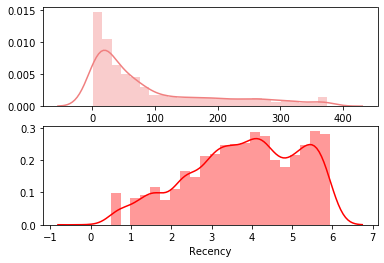

In [46]:
plt.subplot(2,1,1);sns.distplot(rfm.Recency, color = 'lightcoral')

recency_log = np.log(rfm.Recency)
plt.subplot(2,1,2);sns.distplot(recency_log, color='red')
plt.show()

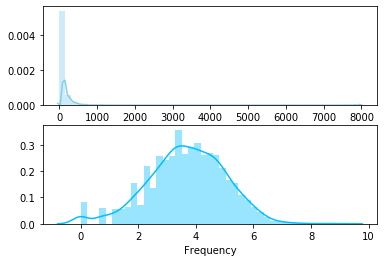

In [47]:
plt.subplot(2,1,1);sns.distplot(rfm.Frequency, color = 'skyblue')

frequency_log = np.log(rfm.Frequency)
plt.subplot(2,1,2); sns.distplot(frequency_log, color='deepskyblue')
plt.show()

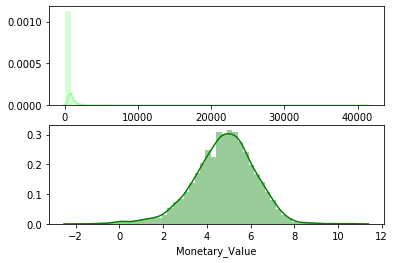

In [48]:
plt.subplot(2,1,1);sns.distplot(rfm.Monetary_Value, color='palegreen')

monetary_log = np.log(rfm.Monetary_Value).round(2)
plt.subplot(2,1,2); sns.distplot(monetary_log, color='green')
plt.show()

### 2. Centering and scalling variables

In [49]:
rfm_log = np.log(rfm[['Recency', 'Frequency', 'Monetary_Value']])

In [50]:
# Manually centering vaiables by subtracting average value from each observation
rfm_centered = rfm_log - rfm_log.mean()
rfm_centered.describe().round(2)

,Recency,Frequency,Monetary_Value
count,4371.00,4371.00,4371.00
mean,-0.00,-0.00,-0.00
std,1.37,1.34,1.41
min,-3.80,-3.68,-6.56
25%,-0.91,-0.85,-0.82
50%,0.13,0.05,0.08
75%,1.17,0.94,0.92
max,2.13,5.30,5.84


In [51]:
# Manually scaling variables by dividing them by the standard square deviation of each variable
rfm_scaled = rfm_log / rfm_log.std()
rfm_scaled.describe().round(2)

,Recency,Frequency,Monetary_Value
count,4371.00,4371.00,4371.00
mean,2.78,2.75,3.39
std,1.00,1.00,1.00
min,0.00,0.00,-1.25
25%,2.11,2.11,2.81
50%,2.87,2.79,3.45
75%,3.63,3.45,4.04
max,4.33,6.70,7.53


In [52]:
# Manually normalize data
rfm_normalized_m = (rfm_log - rfm_log.mean())/rfm_log.std()
rfm_normalized_m.describe().round(2)

,Recency,Frequency,Monetary_Value
count,4371.00,4371.00,4371.00
mean,-0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.78,-2.75,-4.65
25%,-0.66,-0.64,-0.58
50%,0.10,0.04,0.05
75%,0.86,0.70,0.65
max,1.55,3.95,4.13


In [53]:
# To avoid manual transformation, use Stadard Scaller

# Combining centering and scaling automatically
scaler = StandardScaler()
scaler.fit(rfm_log)

# Store seprate array for clustering
rfm_normalized = scaler.transform(rfm_log)

In [56]:
# Converting to dataframe to check if it matches manuall process
rfm_norm = pd.DataFrame(rfm_normalized,index = rfm_log.index, columns=rfm_log.columns)
rfm_norm.describe().round(2)

,Recency,Frequency,Monetary_Value
count,4371.00,4371.00,4371.00
mean,0.00,-0.00,-0.00
std,1.00,1.00,1.00
min,-2.78,-2.75,-4.65
25%,-0.66,-0.64,-0.58
50%,0.10,0.04,0.05
75%,0.86,0.70,0.65
max,1.56,3.96,4.13


#### Shorcut 
***Unskew the data***<br>
rfm_log = np.log(rfm_data)

***Initialize a standard scaler and fit it***<br>
scaler = StandardScaler()<br>
scaler.fit(rfm_log)

***Scale and center the data***<br>
rfm_normalized = scaler.transform(rfm_log)

***Create a pandas DataFrame***<br>
rfm_normalized = pd.DataFrame(data=rfm_normalized, index=rfm_data.index, columns=rfm_data.columns)

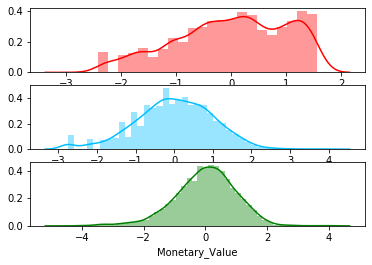

In [57]:
_=plt.subplot(3,1,1); sns.distplot(rfm_norm['Recency'], color='red')
_=plt.subplot(3,1,2); sns.distplot(rfm_norm['Frequency'], color='deepskyblue')
_=plt.subplot(3,1,3); sns.distplot(rfm_norm['Monetary_Value'], color='green')
plt.show()

### Choose a number of clusters with k-means
***Methods for defining number of clusters***<br>
- Visual methods: elbow criterion (plotting # of clusters against sum-of-squared errors)<br>
- Mathmatical methods: silouette coeffcient<br>
- Experimentation and iterperation

In [89]:
### Manual cluster selection ### 
#Initialize kmeans
kmeans = KMeans(n_clusters=3, random_state=1)

# Compute k-means clustering on preprocessed data
kmeans.fit(rfm_norm)

# Extract the cluster labels
cluster_labels = kmeans.labels_
rfm_k_manual = rfm.assign(Cluster = cluster_labels)

# Analyze result
rfm_k_manual.groupby(['Cluster']).agg(Size = ('General_Segment','count'),
                    Recency = ('Recency','mean'), 
                              Frequency = ('Frequency','mean'), 
                              Monetary_Value = ('Monetary_Value','mean')).round(2)

,Size,Recency,Frequency,Monetary_Value
Cluster,,,,
0,1905,117.19,46.51,176.63
1,1477,17.92,209.55,707.80
2,989,158.80,8.81,26.21


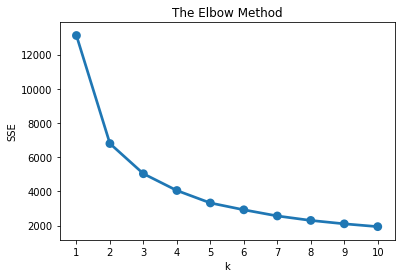

In [66]:
### Elbow criterion ### 

#Fit KMeans and calculate SSE for each k
sse = {}

#Initialize kmeans with k
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_norm)
    sse[k] = kmeans.inertia_ # sum of squared distances to closest cluster center

# Plot SSE for each k
plt.title("The Elbow Method")
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

### Profile and interpret segments

**Aproaches to build customer personas**<br>
- Summary statistics for each cluster e.g. average RFM values
- Snake plots (from market reserach)
- Calculate relative importance of cluster attributes compared to population

In [90]:
# Create a cluster label column in the original df with kmeans solution
# KMeans elbow shows '2' as the best number of clusters
kmeans = KMeans(n_clusters=2, random_state=1)

# Compute k-means clustering on preprocessed data
kmeans.fit(rfm_norm)

# Extract the cluster labels
cluster_labels = kmeans.labels_
rfm_k2 = rfm.assign(K_Cluster = cluster_labels)

In [91]:
# Calculate average RFM values and size for both k=2 and k=3
rfm_k2.groupby(['K_Cluster']).agg(Size = ('General_Segment','count'),
                    Recency = ('Recency','mean'), 
                              Frequency = ('Frequency','mean'), 
                              Monetary_Value = ('Monetary_Value','mean')).round(2)

,Size,Recency,Frequency,Monetary_Value
K_Cluster,,,,
0,2126,34.66,168.74,583.85
1,2245,148.37,21.42,74.19


<font color ='grey'>***Even though the elbow method suggest 2 clusters, 3 gives more insights***</font>

### Snake plots to understand segements
- Market research technique to compare different segments
- Visual representation of each segment's attributes
- Need to first normalize (already done in steps above)

In [114]:
# Choosing only relevant columns where n_clusters = 3
rfm_snake = rfm_k_manual[['Recency', 'Frequency', 'Monetary_Value','Cluster']]

In [115]:
# Melting data into a long format so RFM values and metric names are stored in 1 column each
rfm_melt = pd.melt(rfm_snake.reset_index(),
                  id_vars=['CustomerID','Cluster'],
                  value_vars=['Recency', 'Frequency','Monetary_Value'],
                  var_name='Attribute',
                  value_name='Value')
rfm_melt.head()

,CustomerID,Cluster,Attribute,Value
0,12346,2,Recency,327.0
1,12347,1,Recency,3.0
2,12348,0,Recency,76.0
3,12349,1,Recency,20.0
4,12350,0,Recency,311.0


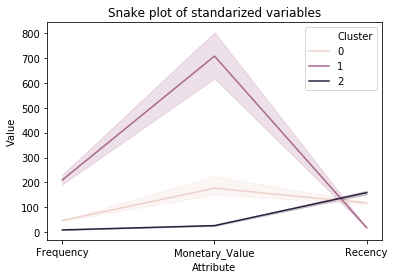

In [116]:
# Visulaize snake plot
plt.title('Snake plot of standarized variables')
sns.lineplot(x='Attribute', y='Value', hue='Cluster', data=rfm_melt)
plt.show()

### Relative importance of segment attributes
- Useful technique to identify relative importance of each segment's attribute
- Calculate average values of each cluster
- Calculate average values of population

In [119]:
cluster_avg = rfm_snake.groupby(['Cluster']).mean()
population_avg = rfm_snake.mean()
population_avg.pop('Cluster')
relative_imp = cluster_avg/population_avg - 1

In [120]:
relative_imp.round(2)

,Recency,Frequency,Monetary_Value
Cluster,,,
0,0.26,-0.50,-0.45
1,-0.81,1.25,1.20
2,0.71,-0.91,-0.92


### Analyze relative importance
- The further a ratio is from 0, the more important that attribute is for segment relative to population

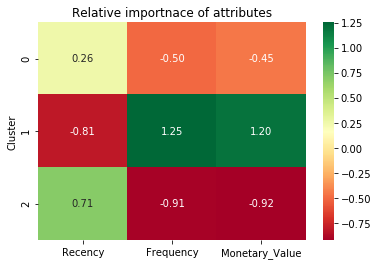

In [128]:
plt.figure(figsize=(6,4))
plt.title('Relative importnace of attributes')
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()